In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data

torch.cuda.set_device(2)
torch.manual_seed(0)

# Load the Datasets

In [58]:
X_train = np.load("./numpy_ds/x_train.npy")
X_val = np.load("./numpy_ds/x_val.npy")
X_test = np.load("./numpy_ds/x_test.npy")

y_train = np.load("./numpy_ds/y_train.npy")
y_val = np.load("./numpy_ds/y_val.npy")
y_test = np.load("./numpy_ds/y_test.npy")

# Designing the Model

In [144]:
class FFSpeechMode(nn.Module):
    def __init__(self):
        super(FFSpeechMode, self).__init__()
        self.activationLayer = nn.PReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(299*13, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 8)
        self.fc5 = nn.Linear(8,3)
    
    def forward(self, x):
        x = self.activationLayer(self.fc1(x))
        #x = self.dropout(x)
        x = self.activationLayer(self.fc2(x))
        x = self.dropout(x)
        x = self.activationLayer(self.fc3(x))
        x = self.activationLayer(self.fc4(x))
        x = self.fc5(x)

        return x

In [135]:
random.seed(0)

def train_ffsm(model, x_tr, y_tr, x_v, y_v, criterion, optimizer, epoch_range, batch_size):
    losses = []
    v_losses = []
   
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, x_tr.shape[0]), batch_size)
        x = np.zeros((batch_size, 299*13))
        y = np.zeros((batch_size, 3))
        for i, feats in enumerate(selected):
            x[i, :] = x_tr[feats, :, :].flatten()
            y[i, :] = y_tr[feats, :]
        x = torch.from_numpy(x).float().cuda()
        y = torch.from_numpy(y).long().cuda()
        #---------FORWARD------------#
        out = model.forward(x)
        out = torch.tensor(out).float().cuda()
        loss = criterion(out, torch.max(y,1)[1])
        #---------BACKWARD------------#
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        v = random.sample(range(0, x_v.shape[0]), 8)
        xv = np.zeros((8, 299*13))
        yv = np.zeros((8, 3))
        for i, feats in enumerate(v):
            xv[i, :] = x_v[feats, :, :].flatten()
            yv[i, :] = y_v[feats, :]
        xv = torch.from_numpy(xv).float().cuda()
        yv = torch.from_numpy(yv).long().cuda()
        v_out = model.forward(xv)
        v_out = torch.tensor(v_out).float().cuda()
        vloss = criterion(v_out, torch.max(yv, 1)[1])
        
        losses.append(loss.data[0])
        v_losses.append(vloss.data[0])
        if num_epoch%100 == 0:
            print('epoch [{}/{}], loss:{:.8f}, val:{:.8f}'.format(num_epoch, epoch_range, 
                                                              loss.data[0], vloss.data[0]))
    return losses, v_losses

In [136]:
def init_weights(layer):
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d:
        nn.init.xavier_normal_(layer.weight)

In [148]:
mdl1 = FFSpeechMode().cuda()
mdl1.apply(init_weights)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = torch.optim.Adam(
    mdl1.parameters(), lr=learning_rate, weight_decay=0.001)

epoch_range = 25000
batch_size = 48
losses, vlosses = train_ffsm(mdl1, X_train, y_train, X_val, y_val, 
                                 criterion, optimizer, epoch_range, batch_size)

/disk/scratch/s1769454/anaconda3/envs/dissertation/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/disk/scratch/s1769454/anaconda3/envs/dissertation/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/disk/scratch/s1769454/anaconda3/envs/dissertation/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [0/25000], loss:67.84915924, val:76.88689423
epoch [100/25000], loss:2.03947425, val:3.01189804
epoch [200/25000], loss:1.09559810, val:0.08345917
epoch [300/25000], loss:0.32568941, val:0.63498622
epoch [400/25000], loss:0.29735947, val:0.53416038
epoch [500/25000], loss:0.03274913, val:2.68624401
epoch [600/25000], loss:0.32067659, val:1.00805783
epoch [700/25000], loss:0.01790656, val:2.83530998
epoch [800/25000], loss:0.02820032, val:0.00166222
epoch [900/25000], loss:0.20658793, val:0.00005388
epoch [1000/25000], loss:0.00094706, val:0.21346444
epoch [1100/25000], loss:0.00131828, val:1.69651580
epoch [1200/25000], loss:0.00141542, val:1.05875373
epoch [1300/25000], loss:0.00081844, val:4.75970364
epoch [1400/25000], loss:0.52131611, val:0.41302371
epoch [1500/25000], loss:0.04189182, val:7.21442175
epoch [1600/25000], loss:0.00031408, val:3.49693918
epoch [1700/25000], loss:0.00376237, val:11.36064529
epoch [1800/25000], loss:0.00071715, val:0.00000000
epoch [1900/25000], l

epoch [15700/25000], loss:0.00001539, val:1.27922583
epoch [15800/25000], loss:0.00006895, val:2.43659592
epoch [15900/25000], loss:0.00021311, val:0.00007874
epoch [16000/25000], loss:0.00003352, val:1.32267511
epoch [16100/25000], loss:0.00000855, val:0.00368565
epoch [16200/25000], loss:0.00011673, val:0.01058304
epoch [16300/25000], loss:0.00000795, val:0.89025265
epoch [16400/25000], loss:0.00001717, val:2.57359600
epoch [16500/25000], loss:0.00005142, val:0.12067425
epoch [16600/25000], loss:0.00001018, val:0.58107352
epoch [16700/25000], loss:0.00005611, val:1.35543406
epoch [16800/25000], loss:0.00005635, val:0.08789036
epoch [16900/25000], loss:0.00002842, val:0.58817172
epoch [17000/25000], loss:0.00015473, val:0.03853506
epoch [17100/25000], loss:0.02243686, val:0.26623082
epoch [17200/25000], loss:0.00061507, val:1.42768979
epoch [17300/25000], loss:0.00067391, val:0.05639488
epoch [17400/25000], loss:0.00016139, val:2.76139998
epoch [17500/25000], loss:0.00057989, val:2.11

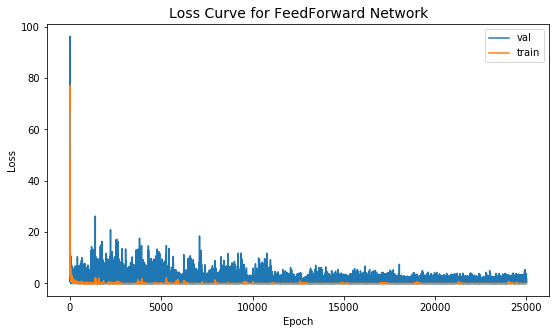

In [151]:
fig = plt.figure(figsize=(9, 5))
plt.title("Loss Curve for FeedForward Network", fontsize=14)
plt.plot(vlosses, label="val")
plt.plot(losses, label="train")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
fig.savefig("./images/ffsm_performance.pdf", bbox_inches='tight')

# Testing on the Test Set

In [150]:
# Indicated by maximum energy

total = y_test.shape[0]
correct = 0

for i in range(X_test.shape[0]):
    data = X_test[i, :, :].flatten()
    #print(data)
    data = torch.from_numpy(data).float().cuda()
    true_out = y_test[i, :]
    mdl_out = mdl1.forward(data)
    out = (mdl_out.data).cpu().numpy()
    if np.argmax(out) == np.argmax(true_out):
        correct += 1
print("Accuracy = ", correct*100/total)

Accuracy =  84.02777777777777


In [152]:
torch.save(mdl1, 'models/feedforward_speechmode.pt')

/disk/scratch/s1769454/anaconda3/envs/dissertation/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type FFSpeechMode. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
